## CREDIT CARD SPEND PREDICTION & IDENTIFY DRIVERS FOR SPEND
###### Definition of Target and Outcome Window
       One of the global banks would like to understand the factors driving credit card spend. The bank also wants to use these insights to predict credit limit for new applicants. 
###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean imputation) and Categorical (mode imputation)
    - Univariate Analysis - Outlier analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Correaltion with target variable
    - Variable Transformation - X_exp, X_log, X_sqrt, X_square
    - Variable Reduction - VIF, SelectKBest, PCA
###### Model Build and Model Evaluation
    - Train and Test split
    - Significance of each Variable
    - Model used :- OLS, Linear Regression, Support Vector Regressor, Random Forest Regressor, Gradient Boosting Regressor,
                    Lasso Regressor, K Neighbors Regressor, XGB Regressor
    - Testing Parameters:- MAE(Mean Absolute Error), MSE(Mean Square Error), RMSE(Root Mean Square Error), 
    - Scoring:- R2, cross_val_score
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas_profiling as pp
from matplotlib.backends.backend_pdf import PdfPages
import statistics as st
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression
%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#Read data
cre_df = pd.read_excel("Data Set.xlsx")
cre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [3]:
# new target variable created after merging variables with same properties.
cre_df['total_spend'] = cre_df['cardspent'] + cre_df['card2spent'] 

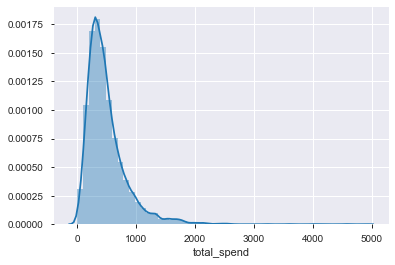

In [4]:
#Visualizing distribution of total_spend
sb.distplot(cre_df['total_spend'])

In [5]:
 #log target taken to normalize the data.
cre_df['log_total_spend'] = np.log(cre_df['total_spend']) 

#variables removed as they are not needed 
cre_df.drop(columns=['custid','total_spend','cardspent','card2spent'],axis=1,inplace=True)

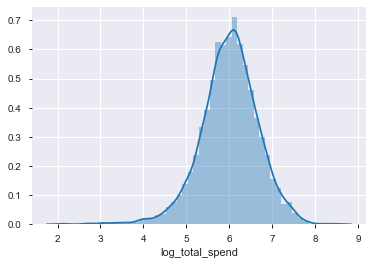

In [6]:
#Visualizing log_total_spend
sb.distplot(cre_df['log_total_spend'])

The log transformation of target variable helped in formation of normal distribution.

In [7]:
#Split data into numerical and categorical 
cre_num = cre_df[["age","ed","income","lninc","debtinc","creddebt","lncreddebt","othdebt","lnothdebt","spoused","reside","pets","pets_cats","pets_dogs","pets_birds","pets_reptiles","pets_small","pets_saltfish","pets_freshfish","carvalue","commutetime","tenure","longmon","lnlongmon","longten","lnlongten","tollmon","lntollmon","tollten","lntollten","equipmon","lnequipmon","equipten","lnequipten","cardmon","lncardmon","cardten","lncardten","wiremon","lnwiremon","wireten","lnwireten","hourstv","log_total_spend"]].copy() 
cre_cat = cre_df[["region","townsize","gender","agecat","birthmonth","edcat","jobcat","union","employ","empcat","retire","inccat","default","jobsat","marital","spousedcat","homeown","hometype","address","addresscat","cars","carown","cartype","carcatvalue","carbought","carbuy","commute","commutecat","commutecar","commutemotorcycle","commutecarpool","commutebus","commuterail","commutepublic","commutebike","commutewalk","commutenonmotor","telecommute","reason","polview","polparty","polcontrib","vote","card","cardtype","cardbenefit","cardfee","cardtenure","cardtenurecat","card2","card2type","card2benefit","card2fee","card2tenure","card2tenurecat","active","bfast","churn","tollfree","equip","callcard","wireless","multline","voice","pager","internet","callid","callwait","forward","confer","ebill","owntv","ownvcr","owndvd","owncd","ownpda","ownpc","ownipod","owngame","ownfax","news","response_01","response_02","response_03"]].copy()

In [8]:
#Remove log variables and categorical variables with numerical features
cre_num1 = cre_num.drop(columns=["lninc","lncreddebt","lnothdebt","lnlongmon","lnlongten","lntollmon","lntollten","lnequipmon","lnequipten","lncardmon","lncardten","lnwiremon","lnwireten"]) 
cre_cat1 = cre_cat.drop(columns=["employ","address","cars","cardtenure","card2tenure"])

## Numerical Features

##### Pandas profiling used to get a brief summary of numerical variables

In [9]:
cre_num1.profile_report()

##### Dropping columns with high percentage of zeros (<=25%)

In [10]:
cre_num2=cre_num1.drop(columns=["cardmon","cardten","equipmon","equipten","pets","pets_birds","pets_cats","pets_dogs","pets_freshfish","pets_reptiles","pets_saltfish","pets_small","tollmon","tollten","wiremon","wireten"])

##### Creating Data audit Report

In [11]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

cre_num2.apply(lambda x: var_summary(x)).T


N  NMISS           SUM        MEAN      MEDIAN  \
age              5000.0    0.0  2.351280e+05   47.025600   47.000000   
ed               5000.0    0.0  7.271500e+04   14.543000   14.000000   
income           5000.0    0.0  2.737980e+05   54.759600   38.000000   
debtinc          5000.0    0.0  4.977080e+04    9.954160    8.800000   
creddebt         5000.0    0.0  9.286628e+03    1.857326    0.926437   
othdebt          5000.0    0.0  1.827230e+04    3.654460    2.098540   
spoused          5000.0    0.0  3.056400e+04    6.112800   -1.000000   
reside           5000.0    0.0  1.102000e+04    2.204000    2.000000   
carvalue         5000.0    0.0  1.161629e+05   23.232580   17.000000   
commutetime      4998.0    2.0  1.266770e+05   25.345538   25.000000   
tenure           5000.0    0.0  1.910240e+05   38.204800   38.000000   
longmon          5000.0    0.0  6.735725e+04   13.471450    9.550000   
longten          4997.0    3.0  3.542232e+06  708.871753  350.000000   
hourstv          5000.0    0.0  9.822500e+04   19.645000   20.000000   
log_total_spend  5000.0    0.0  3.000622e+04    6.001244    6.026470   

                        STD            VAR        MIN         P1         P5  \
age               17.770338     315.784902  18.000000  18.000000  20.000000   
ed                 3.281083      10.765504   6.000000   8.000000   9.000000   
income            55.377511    3066.668742   9.000000   9.000000  13.000000   
debtinc            6.399783      40.957226   0.000000   0.700000   1.900000   
creddebt           3.415732      11.667225   0.000000   0.033160   0.101088   
othdebt            5.395172      29.107876   0.000000   0.114299   0.287692   
spoused            7.743518      59.962069  -1.000000  -1.000000  -1.000000   
reside             1.393977       1.943173   1.000000   1.000000   1.000000   
carvalue          21.231637     450.782397  -1.000000  -1.000000  -1.000000   
commutetime        5.879149      34.564390   8.000000  13.000000  16.000000   
tenure            22.661888     513.561169   0.000000   1.000000   4.000000   
longmon           12.773381     163.159266   0.900000   1.850000   2.900000   
longten          979.291072  959011.004250   0.900000   2.400000  12.620000   
hourstv            5.165609      26.683512   0.000000   0.000000  12.000000   
log_total_spend    0.671473       0.450876   2.093098   4.063844   4.891146   

                       P10         P25         P50         P75          P90  \
age              23.000000   31.000000   47.000000   62.000000    72.000000   
ed               10.000000   12.000000   14.000000   17.000000    19.000000   
income           16.000000   24.000000   38.000000   67.000000   109.100000   
debtinc           2.800000    5.100000    8.800000   13.600000    18.600000   
creddebt          0.175682    0.385520    0.926437    2.063820     4.299470   
othdebt           0.457997    0.980301    2.098540    4.314780     8.062046   
spoused          -1.000000   -1.000000   -1.000000   14.000000    16.000000   
reside            1.000000    1.000000    2.000000    3.000000     4.000000   
carvalue          2.490000    9.200000   17.000000   31.100000    52.910000   
commutetime      18.000000   21.000000   25.000000   29.000000    33.000000   
tenure            7.000000   18.000000   38.000000   59.000000    69.000000   
longmon           3.700000    5.700000    9.550000   16.550000    27.000000   
longten          28.290000  104.600000  350.000000  913.850000  1808.840000   
hourstv          14.000000   17.000000   20.000000   23.000000    26.000000   
log_total_spend   5.215115    5.621424    6.026470    6.422536     6.811382   

                         P95          P99           MAX  
age                76.000000    79.000000     79.000000  
ed                 20.000000    21.000000     23.000000  
income            147.000000   272.010000   1073.000000  
debtinc            22.200000    29.200000     43.100000  
creddebt            6.373010    14.280358    109.

In [12]:
#spoused and carvalue have value -1 converting them to 0
cre_num2.replace(to_replace=-1,value=0,inplace=True)
cre_num2.apply(lambda x: var_summary(x)).T

N  NMISS           SUM        MEAN      MEDIAN  \
age              5000.0    0.0  2.351280e+05   47.025600   47.000000   
ed               5000.0    0.0  7.271500e+04   14.543000   14.000000   
income           5000.0    0.0  2.737980e+05   54.759600   38.000000   
debtinc          5000.0    0.0  4.977080e+04    9.954160    8.800000   
creddebt         5000.0    0.0  9.286628e+03    1.857326    0.926437   
othdebt          5000.0    0.0  1.827230e+04    3.654460    2.098540   
spoused          5000.0    0.0  3.316300e+04    6.632600    0.000000   
reside           5000.0    0.0  1.102000e+04    2.204000    2.000000   
carvalue         5000.0    0.0  1.166599e+05   23.331980   17.000000   
commutetime      4998.0    2.0  1.266770e+05   25.345538   25.000000   
tenure           5000.0    0.0  1.910240e+05   38.204800   38.000000   
longmon          5000.0    0.0  6.735725e+04   13.471450    9.550000   
longten          4997.0    3.0  3.542232e+06  708.871753  350.000000   
hourstv          5000.0    0.0  9.822500e+04   19.645000   20.000000   
log_total_spend  5000.0    0.0  3.000622e+04    6.001244    6.026470   

                        STD            VAR        MIN         P1         P5  \
age               17.770338     315.784902  18.000000  18.000000  20.000000   
ed                 3.281083      10.765504   6.000000   8.000000   9.000000   
income            55.377511    3066.668742   9.000000   9.000000  13.000000   
debtinc            6.399783      40.957226   0.000000   0.700000   1.900000   
creddebt           3.415732      11.667225   0.000000   0.033160   0.101088   
othdebt            5.395172      29.107876   0.000000   0.114299   0.287692   
spoused            7.267447      52.815780   0.000000   0.000000   0.000000   
reside             1.393977       1.943173   1.000000   1.000000   1.000000   
carvalue          21.119979     446.053534   0.000000   0.000000   0.000000   
commutetime        5.879149      34.564390   8.000000  13.000000  16.000000   
tenure            22.661888     513.561169   0.000000   1.000000   4.000000   
longmon           12.773381     163.159266   0.900000   1.850000   2.900000   
longten          979.291072  959011.004250   0.900000   2.400000  12.620000   
hourstv            5.165609      26.683512   0.000000   0.000000  12.000000   
log_total_spend    0.671473       0.450876   2.093098   4.063844   4.891146   

                       P10         P25         P50         P75          P90  \
age              23.000000   31.000000   47.000000   62.000000    72.000000   
ed               10.000000   12.000000   14.000000   17.000000    19.000000   
income           16.000000   24.000000   38.000000   67.000000   109.100000   
debtinc           2.800000    5.100000    8.800000   13.600000    18.600000   
creddebt          0.175682    0.385520    0.926437    2.063820     4.299470   
othdebt           0.457997    0.980301    2.098540    4.314780     8.062046   
spoused           0.000000    0.000000    0.000000   14.000000    16.000000   
reside            1.000000    1.000000    2.000000    3.000000     4.000000   
carvalue          2.490000    9.200000   17.000000   31.100000    52.910000   
commutetime      18.000000   21.000000   25.000000   29.000000    33.000000   
tenure            7.000000   18.000000   38.000000   59.000000    69.000000   
longmon           3.700000    5.700000    9.550000   16.550000    27.000000   
longten          28.290000  104.600000  350.000000  913.850000  1808.840000   
hourstv          14.000000   17.000000   20.000000   23.000000    26.000000   
log_total_spend   5.215115    5.621424    6.026470    6.422536     6.811382   

                         P95          P99           MAX  
age                76.000000    79.000000     79.000000  
ed                 20.000000    21.000000     23.000000  
income            147.000000   272.010000   1073.000000  
debtinc            22.200000    29.200000     43.100000  
creddebt            6.373010    14.280358    109.

##### Visualzing outliers for numerical features

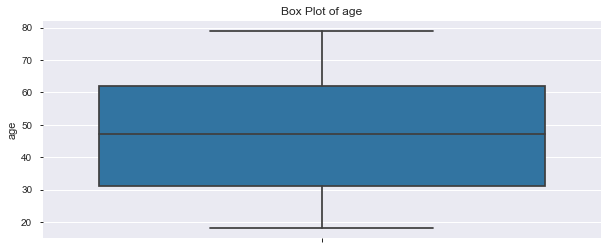

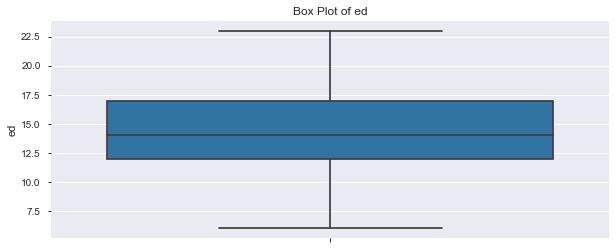

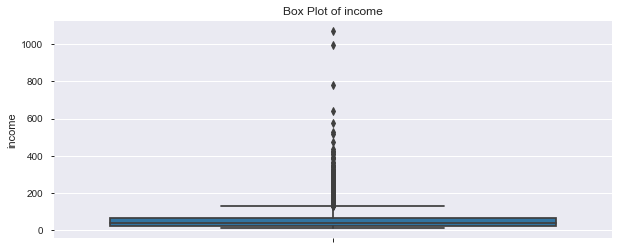

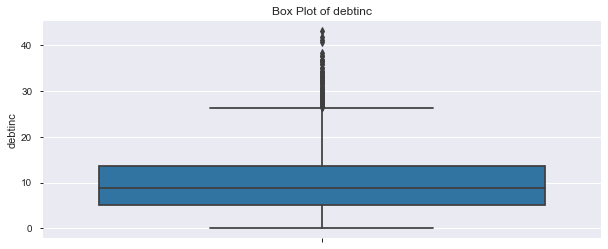

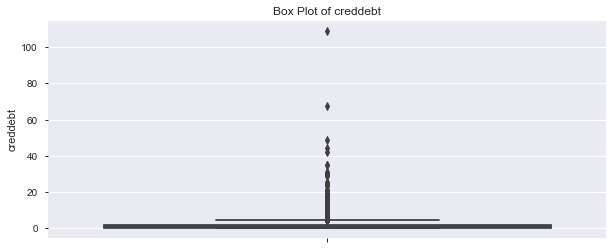

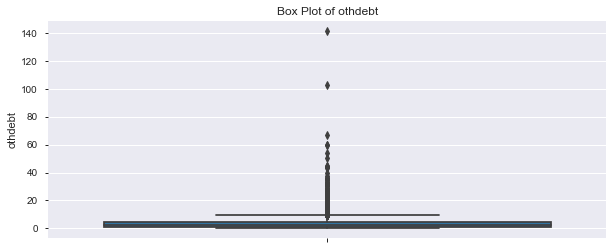

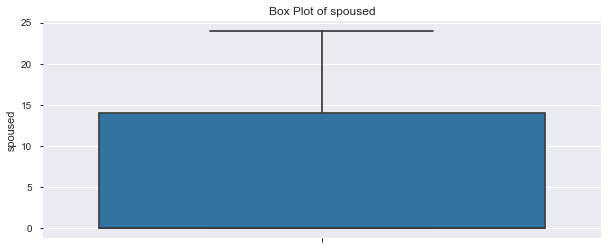

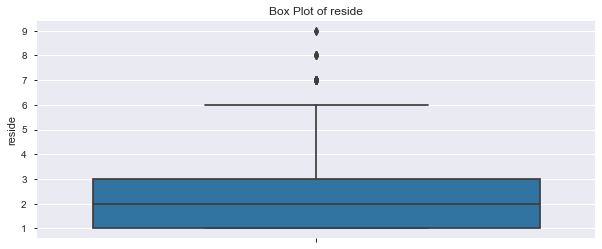

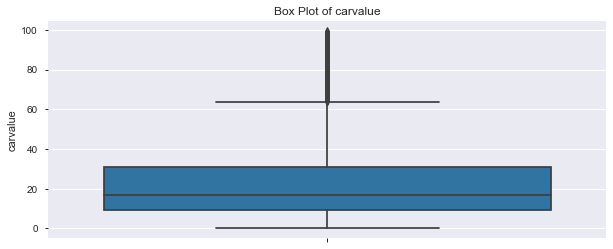

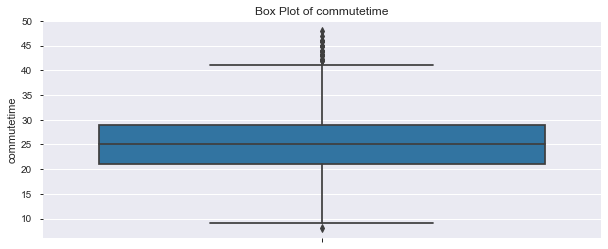

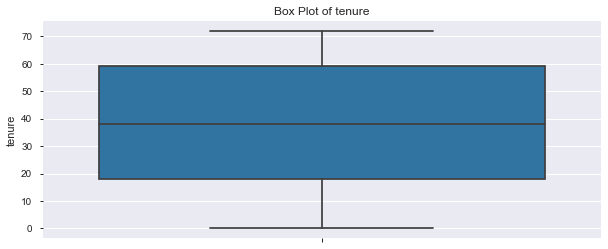

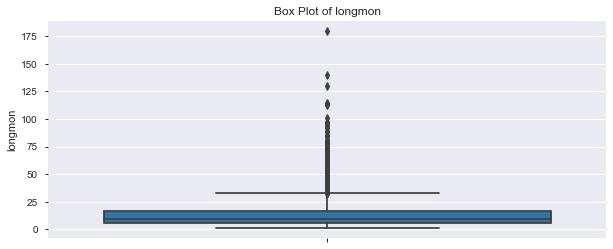

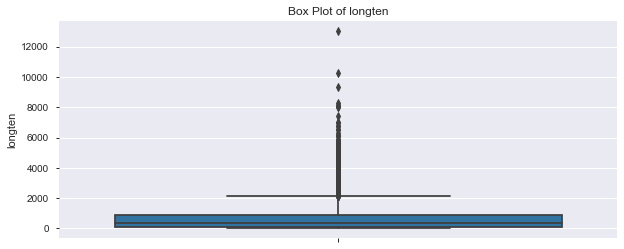

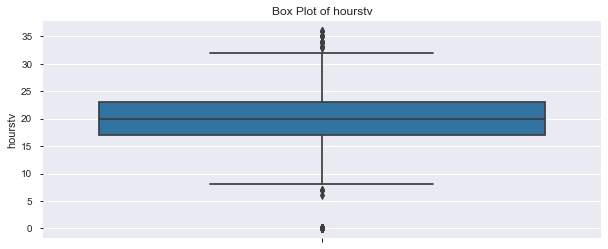

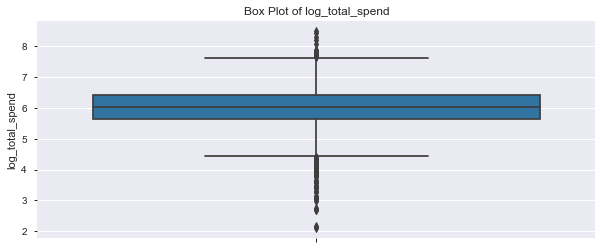

In [13]:
bp = PdfPages('BoxPlots for outlier detection.pdf')
for num_variable in cre_num2.columns:
    fig,axes = plt.subplots(figsize=(10,4))
    sb.boxplot(y=num_variable, data = cre_num2)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

Most of the attributes have outliers

##### Outlier treatment clipping at 5% and 90 %

In [14]:
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.90))
    x = x.clip_lower(x.quantile(0.05))
    return x

cre_num2=cre_num2.apply(lambda x: outlier_capping(x))

##### Reviewing if all outliers have been fixed

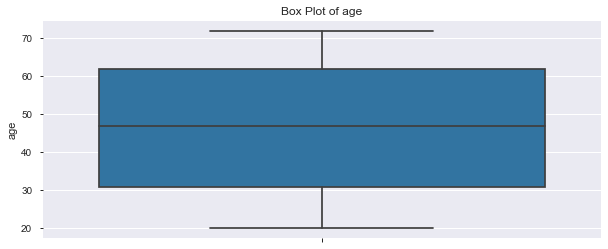

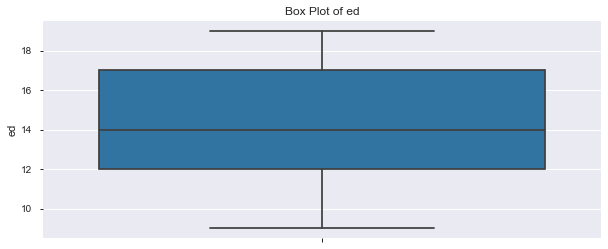

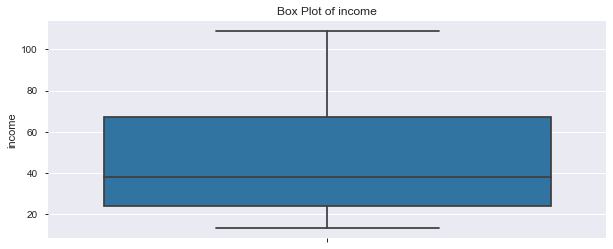

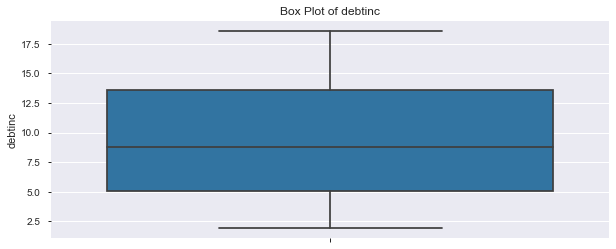

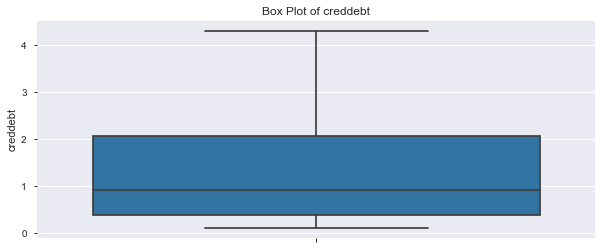

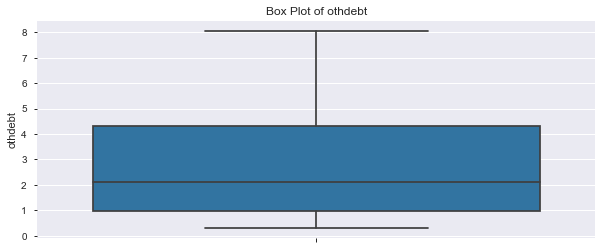

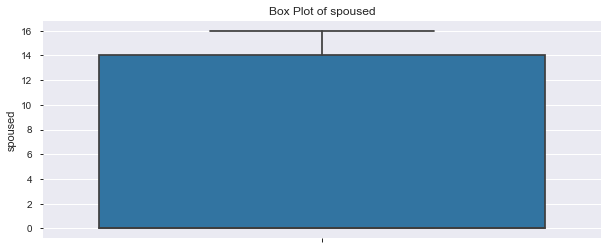

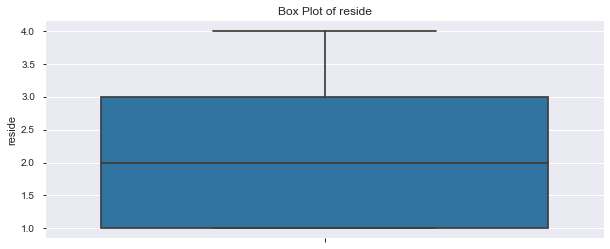

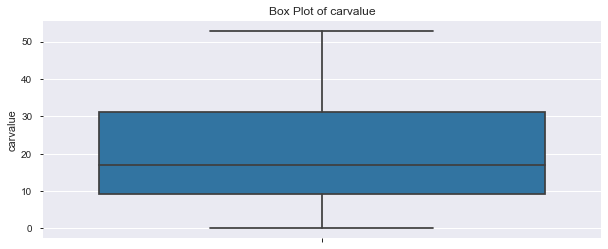

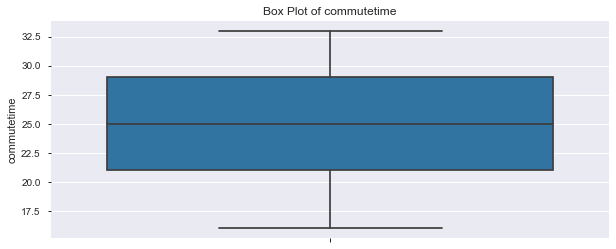

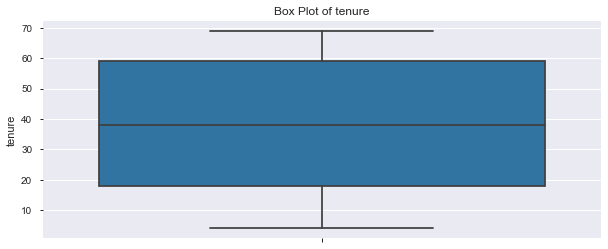

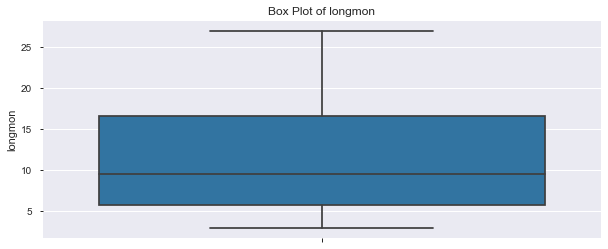

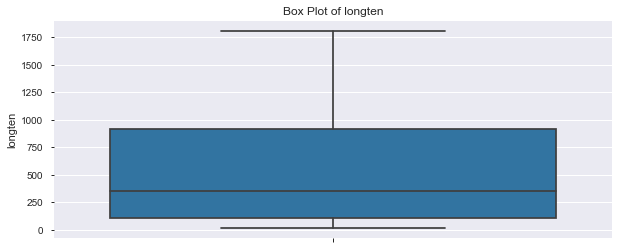

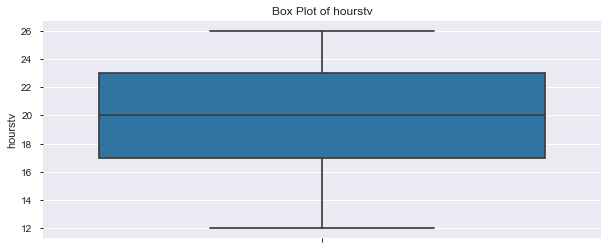

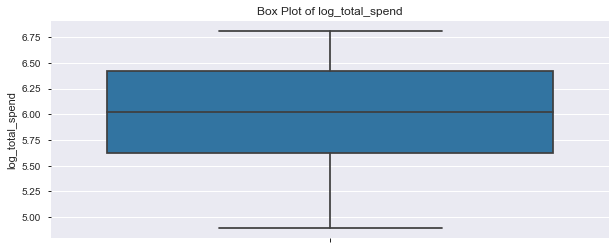

In [15]:
bp = PdfPages('BoxPlots for outlier detection 2.pdf')

for num_variable in cre_num2.columns:
    fig,axes = plt.subplots(figsize=(10,4))
    sb.boxplot(y=num_variable, data = cre_num2)
    plt.title(str('Box Plot of ') + str(num_variable))
    bp.savefig(fig)
bp.close()

##### Handling Missings values

In [16]:
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

cre_num2=cre_num2.apply(lambda x: Missing_imputation(x))

In [17]:
cre_num2.apply(lambda x: var_summary(x)).round(2).T

N  NMISS         SUM    MEAN  MEDIAN     STD        VAR  \
age              5000.0    0.0   233491.00   46.70   47.00   17.07     291.23   
ed               5000.0    0.0    72365.00   14.47   14.00    3.02       9.10   
income           5000.0    0.0   240380.00   48.08   38.00   30.32     919.41   
debtinc          5000.0    0.0    47498.80    9.50    8.80    5.23      27.33   
creddebt         5000.0    0.0     7150.59    1.43    0.93    1.33       1.77   
othdebt          5000.0    0.0    14727.76    2.95    2.10    2.46       6.04   
spoused          5000.0    0.0    31966.00    6.39    0.00    6.89      47.46   
reside           5000.0    0.0    10409.00    2.08    2.00    1.13       1.27   
carvalue         5000.0    0.0   106372.50   21.27   17.00   16.09     259.02   
commutetime      5000.0    0.0   125550.22   25.11   25.00    5.06      25.58   
tenure           5000.0    0.0   190344.00   38.07   38.00   22.19     492.26   
longmon          5000.0    0.0    59516.65   11.90    9.55    7.63      58.18   
longten          5000.0    0.0  2945066.94  589.01  350.20  594.16  353028.26   
hourstv          5000.0    0.0    98344.00   19.67   20.00    4.07      16.58   
log_total_spend  5000.0    0.0    29976.73    6.00    6.03    0.55       0.30   

                   MIN     P1     P5    P10     P25     P50     P75      P90  \
age              20.00  20.00  20.00  23.00   31.00   47.00   62.00    72.00   
ed                9.00   9.00   9.00  10.00   12.00   14.00   17.00    19.00   
income           13.00  13.00  13.00  16.00   24.00   38.00   67.00   109.01   
debtinc           1.90   1.90   1.90   2.80    5.10    8.80   13.60    18.60   
creddebt          0.10   0.10   0.10   0.18    0.39    0.93    2.06     4.30   
othdebt           0.29   0.29   0.29   0.46    0.98    2.10    4.31     8.06   
spoused           0.00   0.00   0.00   0.00    0.00    0.00   14.00    16.00   
reside            1.00   1.00   1.00   1.00    1.00    2.00    3.00     4.00   
carvalue          0.00   0.00   0.00   2.49    9.20   17.00   31.10    52.90   
commutetime      16.00  16.00  16.00  18.00   21.00   25.00   29.00    33.00   
tenure            4.00   4.00   4.00   7.00   18.00   38.00   59.00    69.00   
longmon           2.90   2.90   2.90   3.70    5.70    9.55   16.55    27.00   
longten          12.62  12.62  12.65  28.34  104.64  350.20  913.51  1808.80   
hourstv          12.00  12.00  12.00  14.00   17.00   20.00   23.00    26.00   
log_total_spend   4.89   4.89   4.89   5.22    5.62    6.03    6.42     6.81   

                     P95      P99      MAX  
age                72.00    72.00    72.00  
ed                 19.00    19.00    19.00  
income            109.10   109.10   109.10  
debtinc            18.60    18.60    18.60  
creddebt            4.30     4.30     4.30  
othdebt             8.06     8.06     8.06  
spoused            16.00    16.00    16.00  
reside              4.00     4.00     4.00  
carvalue           52.91    52.91    52.91  
commutetime        33.00    33.00    33.00  
tenure             69.00    69.00    69.00  
longmon            27.00    27.00    27.00  
longten          1808.84  1808.84  1808.84  
hourstv            26.00    26.00    26.00  
log_total_spend     6.81     6.81     6.81

There are no missing values present in numerical variables

##### Numerical variables are being tranfomred to different types ( X(default), X_squared(squared), X_sqrt(squareroot), X_ln(log), X_exp(exponential)) to check which type correlates better with target variable.

In [18]:
def check_transformation(df,target):
    squared = (df**2).add_suffix("_squared") #squared
    square_root = (df**0.5).add_suffix("_sqrt") #square root
    natural_log = np.log(df+1).add_suffix("_ln") #log 
    exp = np.exp(df).add_suffix("_exp") # exponent
    
    transform_squared = pd.concat([df, squared], axis=1) #concatenating all newly created variables
    transform_squared.drop(columns=[str(target)+'_squared'],axis=1,inplace=True) #dropping conversions of target variables.
    
    transform_square_root = pd.concat([df, square_root], axis=1) #concatenating all newly created variables
    transform_square_root.drop(columns=[str(target)+'_sqrt'],axis=1,inplace=True) #dropping conversions of target variables.
    
    transform_natural_log = pd.concat([df, natural_log], axis=1) #concatenating all newly created variables
    transform_natural_log.drop(columns=[str(target)+'_ln'],axis=1,inplace=True) #dropping conversions of target variables.
    
    transform_exp = pd.concat([df, exp], axis=1) #concatenating all newly created variables
    transform_exp.drop(columns=[str(target)+'_exp'],axis=1,inplace=True) #dropping conversions of target variables.
    
    complete_transform = pd.concat([df, squared, square_root, natural_log, exp], axis=1) #concatenating all newly created variables
    complete_transform.drop(columns=[str(target)+'_squared', str(target)+'_sqrt', str(target)+'_ln', str(target)+'_exp'],axis=1,inplace=True) #dropping conversions of target variables. 
        
    return transform_squared, transform_square_root, transform_natural_log, transform_exp, complete_transform
    
def corr_plot(data,target):
    q=data.corr()
    q = pd.DataFrame(q[str(target)])
    q.reset_index(inplace=True)
    q.columns = ['columns','row_value']
    plt.figure(figsize=(15,15))
    q.sort_values(by=['columns'],ascending=False,inplace=True)
    plt.barh(q['columns'],width=q['row_value'],align='center',color=['r','g'],)    

In [19]:
a,b,c,d,e=check_transformation(cre_num2,'log_total_spend')

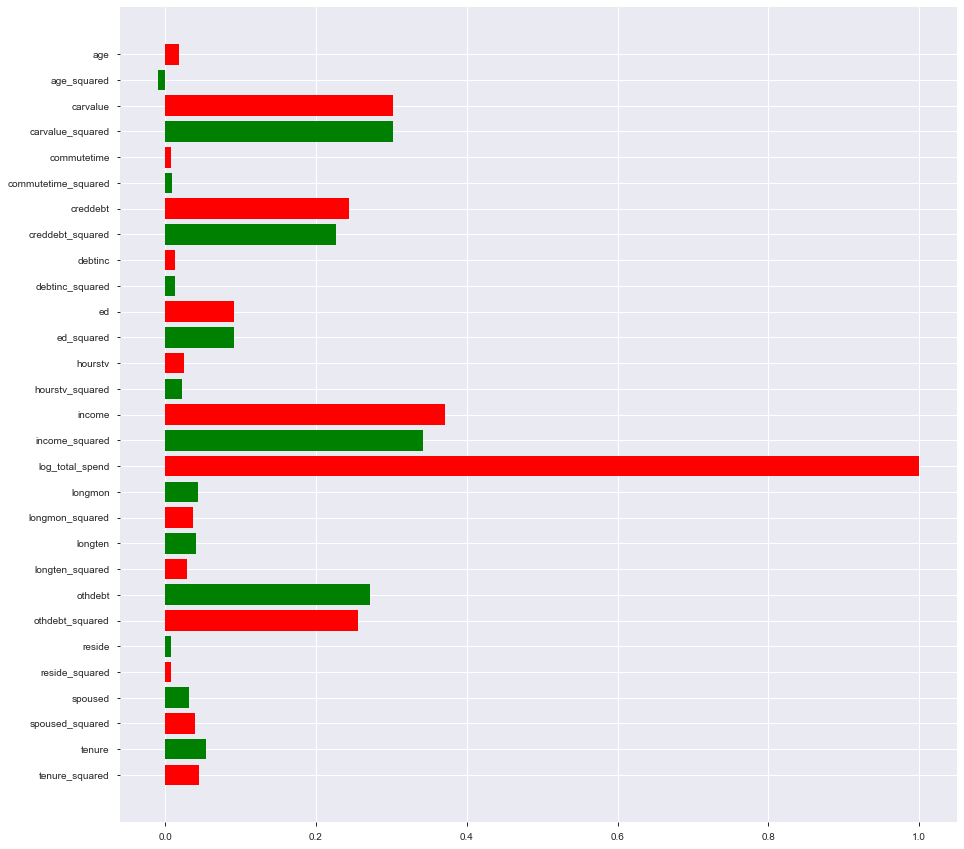

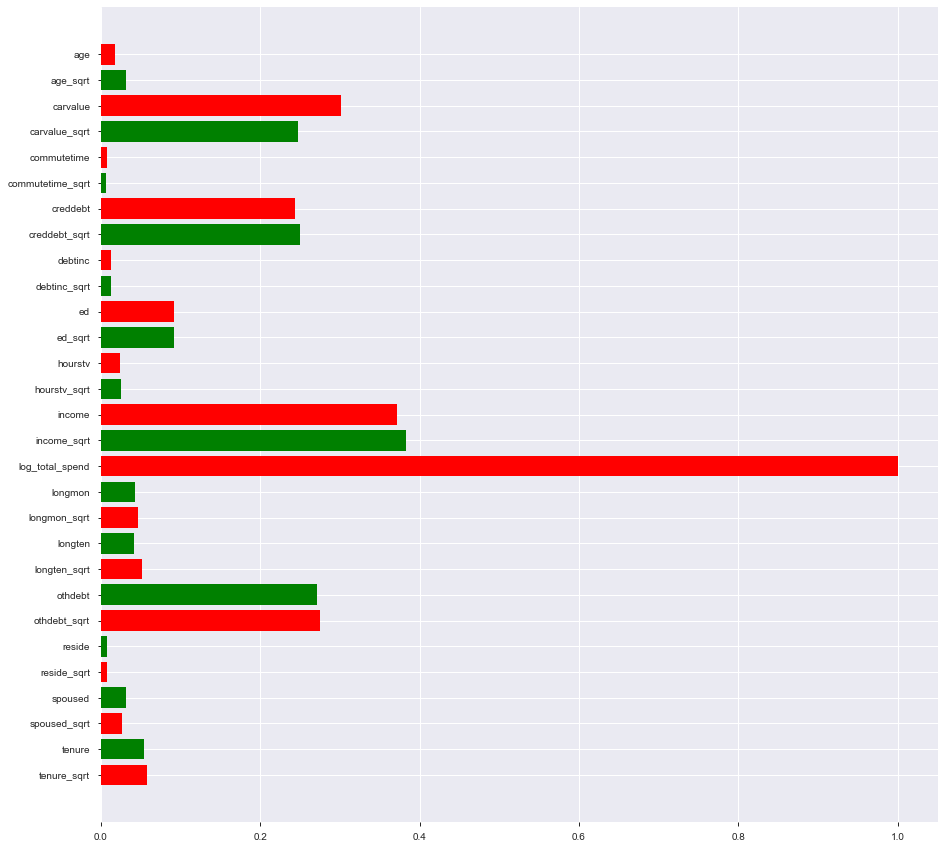

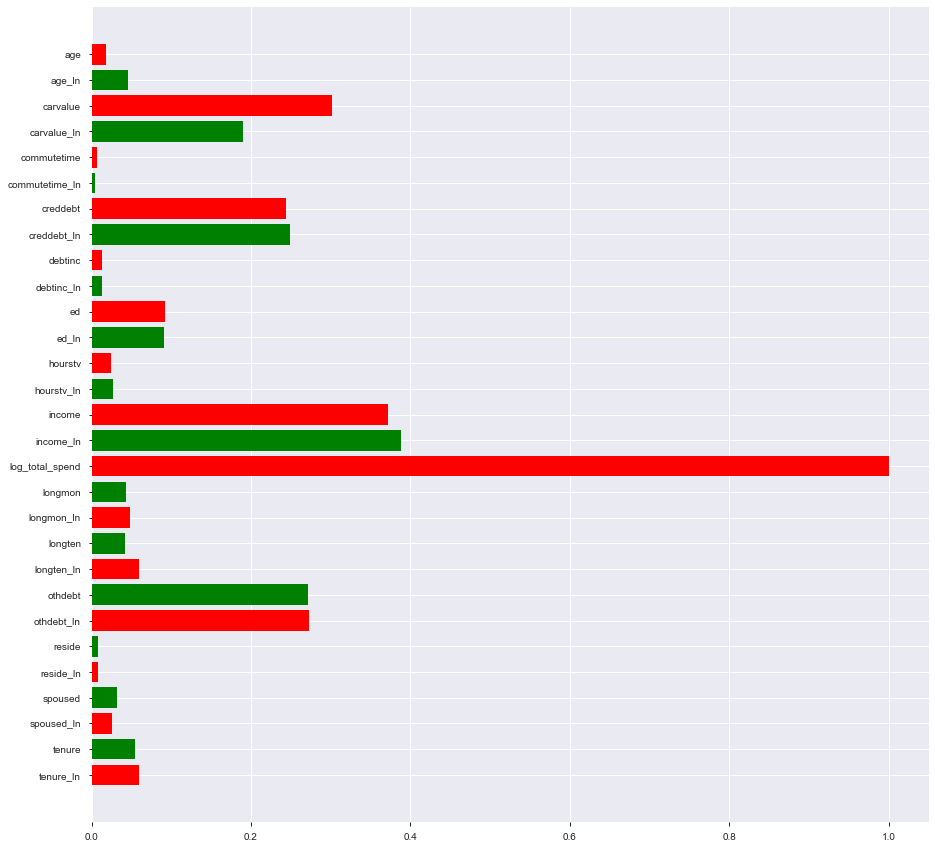

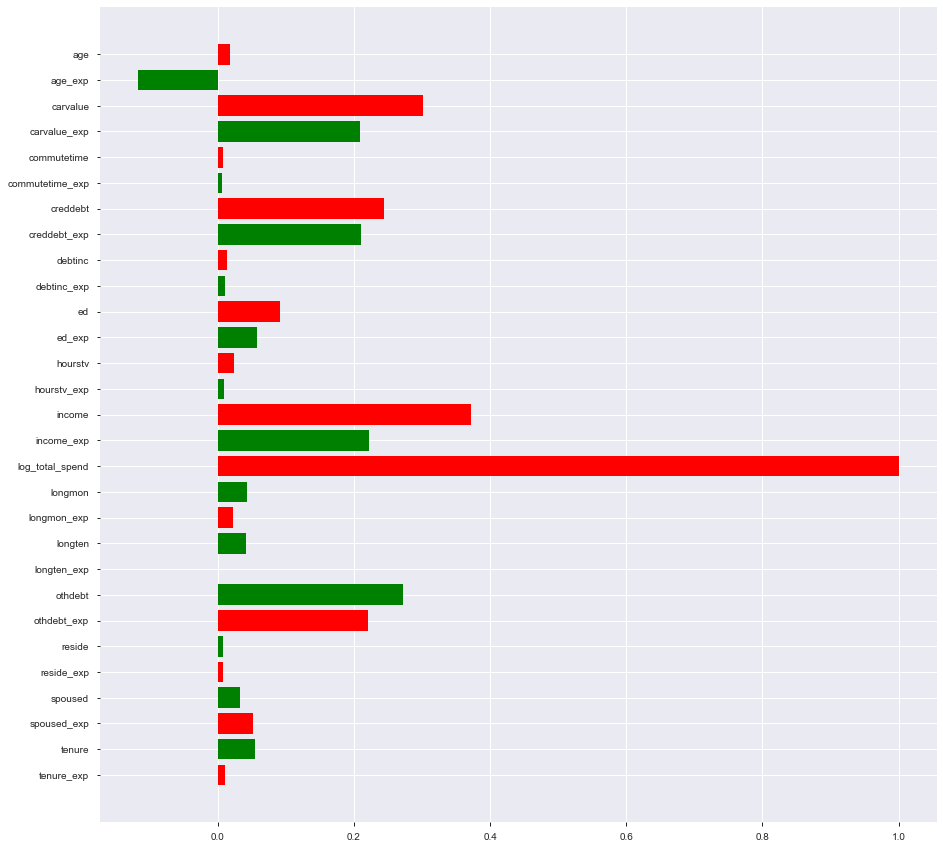

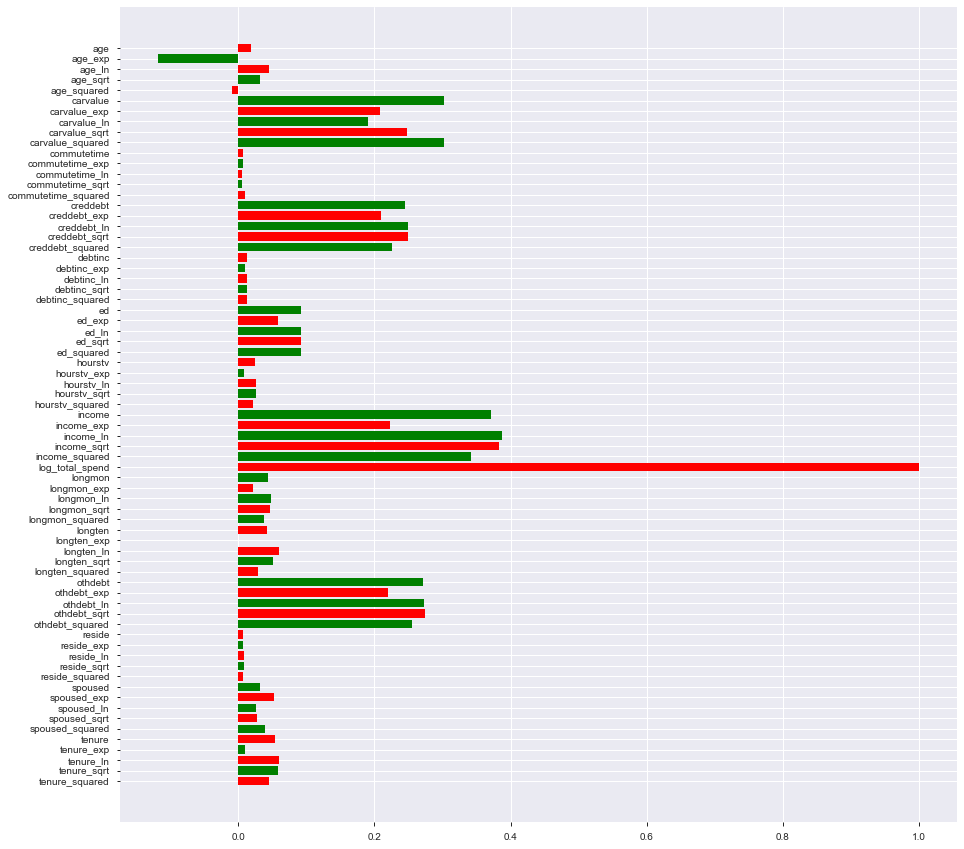

In [20]:
corr_plot(a,'log_total_spend')
corr_plot(b,'log_total_spend')
corr_plot(c,'log_total_spend')
corr_plot(d,'log_total_spend')
corr_plot(e,'log_total_spend')

The transformation of variables does not display a drastic increase in correaltion value. Hence forth the original values will be taken further.

## Categorical Features

##### Creating summary of categorical variables 

In [21]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])
cat_sum=cre_cat1.apply(lambda x: cat_summary(x)).T

In [22]:
cat_sum.sort_values(by=["NMISS"],ascending=False) 

N NMISS                                       ColumnsNames
townsize     4998     2  1.0    1436
2.0    1048
3.0     907
4.0     85...
card         5000     0  4    1344
2    1247
3    1200
1     986
5     ...
multline     5000     0   0    2558
1    2442
Name: multline, dtype: int64
wireless     5000     0   0    3656
1    1344
Name: wireless, dtype: int64
callcard     5000     0   1    3581
0    1419
Name: callcard, dtype: int64
...           ...   ...                                                ...
commutecar   5000     0  1    3395
0    1605
Name: commutecar, dtype: i...
commutecat   5000     0  1    2905
3     981
4     666
2     295
5     ...
commute      5000     0  1     2855
4      635
8      585
5      302
3 ...
carbuy       5000     0     0    3195
1    1805
Name: carbuy, dtype: int64
response_03  5000     0  0    4487
1     513
Name: response_03, dtype: ...

[79 rows x 3 columns]

'townsize' have 2 missing values. Will have to fill it with mode.

In [23]:
cre_cat1['townsize'].mode() #finding mode of townsize

0    1.0
dtype: float64

In [24]:
cre_cat2=cre_cat1.fillna(1.0) #handling missing values in townsize

In [25]:
cre_cat2.iloc[[961,2731]]#overview of rows with missing values in townsize

region  townsize  gender  agecat birthmonth  edcat  jobcat  union  \
961        1       1.0       1       4    January      4       3      0   
2731       5       1.0       1       6   February      3       6      0   

      empcat  retire  ...  owncd  ownpda  ownpc  ownipod  owngame  ownfax  \
961        4       0  ...      1       1      1        1        1       1   
2731       5       1  ...      1       0      0        0        0       0   

      news  response_01  response_02  response_03  
961      0            0            0            0  
2731     0            0            0            0  

[2 rows x 79 columns]

In [26]:
#Extracting a list of column names
columns=pd.DataFrame(cre_cat2.columns)
columns.columns=['col']

##### Creating dummy variables for all the categorical features

In [27]:
cre_cat3=pd.get_dummies(cre_cat2,prefix=cre_cat2.columns,columns=columns.col)
cre_cat3

region_1  region_2  region_3  region_4  region_5  townsize_1.0  \
0            1         0         0         0         0             0   
1            0         0         0         0         1             0   
2            0         0         1         0         0             0   
3            0         0         0         1         0             0   
4            0         1         0         0         0             0   
...        ...       ...       ...       ...       ...           ...   
4995         0         1         0         0         0             0   
4996         0         0         1         0         0             0   
4997         0         0         0         1         0             0   
4998         1         0         0         0         0             1   
4999         0         0         1         0         0             0   

      townsize_2.0  townsize_3.0  townsize_4.0  townsize_5.0  ...  ownfax_0  \
0                1             0             0             0  ...         1   
1                0             0             0             1  ...         0   
2                0             0             1             0  ...         1   
3                0             1             0             0  ...         1   
4                1             0             0             0  ...         1   
...            ...           ...           ...           ...  ...       ...   
4995             1             0             0             0  ...         1   
4996             0             1             0             0  ...         1   
4997             0             0             0             1  ...         1   
4998             0             0             0             0  ...         1   
4999             0             0             0             1  ...         1   

      ownfax_1  news_0  news_1  response_01_0  response_01_1  response_02_0  \
0            0       1       0              1              0              0   
1            1       0       1              1              0              1   
2            0       0       1              1              0              1   
3            0       0       1              0              1              1   
4            0       1       0              1              0              0   
...        ...     ...     ...            ...            ...            ...   
4995         0       0       1              1              0              1   
4996         0       1       0              1              0              1   
4997         0       0       1              1              0              1   
4998         0       0       1              1              0              1   
4999         0       1       0              1              0              1   

      response_02_1  response_03_0  response_03_1  
0                 1              1              0  
1                 0              1              0  
2                 0              1              0  
3                 0              1              0  
4                 1              1              0  
...             ...            ...            ...  
4995              0              1              0  
4996              0              1              0  
4997              0              1              0  
4998              0              1              0  
4999              0              1              0  

[5000 rows x 250 columns]

In [28]:
#Cleaned dataset combined
clean_df = pd.concat([cre_num2,cre_cat3],axis=1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 265 entries, age to response_03_1
dtypes: float64(9), int64(6), uint8(250)
memory usage: 1.8 MB


## Variable Reduction

##### Extracting columns with variance higher > 10%


In [29]:
#Saving variance with column names to new dataframe
check=pd.DataFrame(clean_df.var())

#Renaming the column
check.columns = ['var_val']

#Filtering out variables with variance >10% and resetting index
var = (pd.DataFrame(check[check['var_val']>0.1])).reset_index()

#Renaming the column
var.columns = ['col','var_val'] 

#Saving filtered columns
clean_df2 = clean_df[var.col]
clean_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 203 entries, age to response_02_1
dtypes: float64(9), int64(6), uint8(188)
memory usage: 1.5 MB


##### Analyzing the correlation of independent variables with target variables 


In [30]:
#Columns having corr value with respect to target variable greater then 0.1 or less than -0.1 have been saved, rest were removed.
cor = clean_df2.corr()
cor = pd.DataFrame(cor['log_total_spend'])
c1 = cor[cor['log_total_spend'] > 0.1]
c2 = cor[cor['log_total_spend'] < -0.1]
c3 = pd.concat([c1,c2],axis=0)
c3.reset_index(inplace=True)
c3.columns = ['col','value']
cor_df = clean_df2[c3.col]
cor_df

income  creddebt   othdebt  carvalue  log_total_spend  agecat_5  \
0       31.0  1.200909  2.240091     14.30         5.007029         0   
1       15.0  1.222020  1.567980      6.80         4.891146         0   
2       35.0  0.928620  2.536380     18.80         5.886021         0   
3       20.0  0.101088  1.117200      8.70         5.884464         0   
4       23.0  0.214659  0.287692     10.60         6.230147         0   
...      ...       ...       ...       ...              ...       ...   
4995   109.1  4.299470  7.745920     52.91         6.811382         0   
4996    83.0  3.336600  8.062046     40.00         5.903589         1   
4997   108.0  3.557520  8.062046     52.91         6.811382         0   
4998   109.1  4.299470  8.062046     52.91         6.623999         0   
4999    77.0  2.267650  2.506350     49.30         6.010924         0   

      retire_0  inccat_3  inccat_4  carown_1  carcatvalue_3  card_1  card2_1  \
0            1         0         0         1              0       0        0   
1            1         0         0         1              0       0        0   
2            1         0         0         1              0       0        0   
3            1         0         0         1              0       0        0   
4            1         0         0         0              0       0        1   
...        ...       ...       ...       ...            ...     ...      ...   
4995         1         0         0         1              1       1        0   
4996         1         0         1         1              1       0        0   
4997         1         0         1         1              1       1        0   
4998         1         0         0         1              1       0        0   
4999         1         0         1         1              1       0        0   

      retire_1  inccat_1  carown_0  carcatvalue_1  card_2  card_3  
0            0         0         0              1       0       1  
1            0         1         0              1       1       0  
2            0         0         0              1       1       0  
3            0         1         0              1       1       0  
4            0         1         1              1       0       0  
...        ...       ...       ...            ...     ...     ...  
4995         0         0         0              0       0       0  
4996         0         0         0              0       0       1  
4997         0         0         0              0       0       0  
4998         0         0         0              0       0       1  
4999         0         0         0              0       0       1  

[5000 rows x 19 columns]

##### Splitting data into dependent and independent categories

In [31]:
def split(data):
    features_log = data.columns.difference(['log_total_spend'])
    feat_log = data[features_log]
    pre_log = data["log_total_spend"].copy()
    return feat_log, pre_log

In [32]:
feat,pre = split(cor_df)

##### Variance Inflation Factor analysis on cleaned data

In [33]:
drop=['income','carvalue','retire_0'] #Attributes with vif greater then 10 dropped one at a time
vif_data = feat.drop(drop,axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
vif["features"] = vif_data.columns
vif.sort_values(by='VIF Factor', ascending=False)

VIF Factor       features
8     7.886607       carown_1
1     5.323357  carcatvalue_1
13    4.821685        othdebt
9     3.795409       creddebt
7     2.773538       carown_0
2     2.278501  carcatvalue_3
10    2.190410       inccat_1
11    1.830134       inccat_3
12    1.708025       inccat_4
5     1.675333         card_2
6     1.630773         card_3
4     1.569985         card_1
14    1.509514       retire_1
0     1.440714       agecat_5
3     1.256501        card2_1

In [34]:
vif_feat = vif_data[vif.features] #Final data set after VIF 
vif_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
agecat_5         5000 non-null uint8
carcatvalue_1    5000 non-null uint8
carcatvalue_3    5000 non-null uint8
card2_1          5000 non-null uint8
card_1           5000 non-null uint8
card_2           5000 non-null uint8
card_3           5000 non-null uint8
carown_0         5000 non-null uint8
carown_1         5000 non-null uint8
creddebt         5000 non-null float64
inccat_1         5000 non-null uint8
inccat_3         5000 non-null uint8
inccat_4         5000 non-null uint8
othdebt          5000 non-null float64
retire_1         5000 non-null uint8
dtypes: float64(2), uint8(13)
memory usage: 141.7 KB


##### Select K Best

In [35]:
#Using Kbest to select 15 variables
def kbest(x,y):
    k = SelectKBest(f_regression, k=15).fit_transform(x, y)
    return k

In [36]:
kbest_feat=kbest(feat,pre)
kbest_feat

array([[1.       , 0.       , 0.       , ..., 2.240091 , 1.       ,
        0.       ],
       [1.       , 0.       , 0.       , ..., 1.56798  , 1.       ,
        0.       ],
       [1.       , 0.       , 0.       , ..., 2.53638  , 1.       ,
        0.       ],
       ...,
       [0.       , 1.       , 0.       , ..., 8.0620461, 1.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 8.0620461, 1.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 2.50635  , 1.       ,
        0.       ]])

##### PCA

In [37]:
#pca done on independent variables to select 15 variables
def pca(x):
    scaler = StandardScaler()
    scaler.fit(x)
    train_img = scaler.transform(x)
    
    pca = PCA( n_components=15, random_state=123)    
    pca.fit(x)
    pca_feat = pca.transform(x) #We'll use pca_feat as set of independent variable 
    pca.explained_variance_ratio_.round(3)
    
    return pca_feat

In [38]:
pca_feat=pca(feat)
pca_feat

array([[-1.84315829e+01, -1.01760972e+00, -2.97088377e-01, ...,
         2.01264397e-01, -7.27300566e-02, -5.46965525e-03],
       [-3.61132285e+01, -1.09176827e+00, -6.27062331e-01, ...,
        -3.36263802e-01, -1.04084854e-01,  4.80978270e-02],
       [-1.28906394e+01, -3.37172224e+00, -2.42783276e-01, ...,
         1.88552009e-01, -8.25729887e-02, -2.99227796e-02],
       ...,
       [ 6.79116292e+01, -2.86566662e+00, -1.85081652e+00, ...,
         1.03407132e-01, -2.35377054e-01,  2.83836472e-01],
       [ 6.89141236e+01, -2.39356602e+00, -2.02390851e+00, ...,
        -2.25523091e-01, -1.47049731e-01, -5.20536967e-01],
       [ 3.80959151e+01, -1.29734815e+01,  1.97105805e+00, ...,
         4.58743006e-01, -9.81636901e-02,  3.01731367e-01]])

## Model Building

In [39]:
# Function to build OLS, check summary and visualize any residual outliers using Cooks's distance
def model_ols(model,x,y):
    #splitting data in to train and test
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 123)
    #adding constant to independent train and test sets
    train_x=sm.add_constant(train_x)
    test_x=sm.add_constant(test_x)
    #Fitting model
    mod = ols(train_y,train_x).fit()
    print(mod.summary())
    #Storing summary frame
    o = (mod.get_influence()).summary_frame()
    #Plotting a scatter plot for standardized residuals and Cooks distance
    plt.figure(figsize=(8,5))
    plt.scatter(o.standard_resid,o.cooks_d)
    print(plt.show())
    return o

# Function to build and evaluate other models
def model_build_cum_evaluation(model,x,y):
    #Splitting data in to train and test
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 123)
    #Fitting model
    model.fit(train_x,train_y)
    #Predicting values for train_x and test_x
    model_check = model.predict(train_x)
    model_pred = model.predict(test_x)
    
    #Printing error metrices, r2 score and also cross validating the model.
    print ('MAE:', metrics.mean_absolute_error(test_y, model_pred))
    print ('MSE train:', metrics.mean_squared_error(train_y, model_check))
    print ('MSE test:', metrics.mean_squared_error(test_y, model_pred))
    print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, model_pred)))
    print ('R2: ', metrics.r2_score(test_y, model_pred))
    print ('Cross_val:',cross_val_score(model, x, y,n_jobs=-1,cv=50,scoring='r2').mean()*100)

OLS for final dataset
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     96.31
Date:                Mon, 30 Dec 2019   Prob (F-statistic):          7.89e-249
Time:                        04:18:18   Log-Likelihood:                -2313.5
No. Observations:                3500   AIC:                             4659.
Df Residuals:                    3484   BIC:                             4758.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.7573

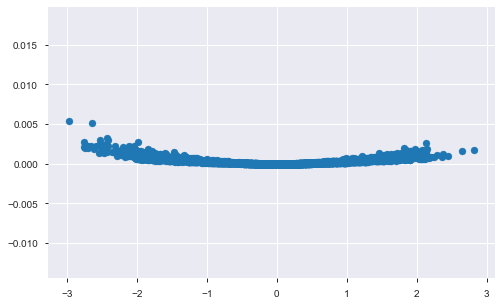

None

OLS for final dataset after pca
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     102.1
Date:                Mon, 30 Dec 2019   Prob (F-statistic):          7.64e-262
Time:                        04:18:34   Log-Likelihood:                -2283.2
No. Observations:                3500   AIC:                             4598.
Df Residuals:                    3484   BIC:                             4697.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

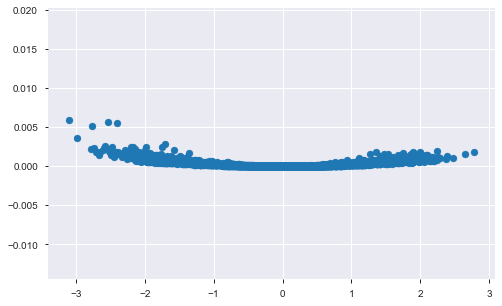

None

OLS for final dataset after selectkbest
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     108.5
Date:                Mon, 30 Dec 2019   Prob (F-statistic):          5.24e-261
Time:                        04:18:50   Log-Likelihood:                -2287.5
No. Observations:                3500   AIC:                             4605.
Df Residuals:                    3485   BIC:                             4697.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

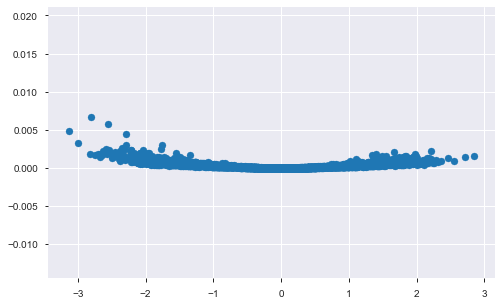

None


In [40]:
#OLS on original data set
ols=sm.OLS
print('OLS for final dataset')
a=model_ols(ols,vif_feat,pre)
print()
print('OLS for final dataset after pca')
b=model_ols(ols,pca_feat,pre)
print()
print('OLS for final dataset after selectkbest')
c=model_ols(ols,kbest_feat,pre)

From the data given above we can observe that there are certaiin outliers that are affecting the model.
We'll take the orginal data set and remove the outliers using cooks distance.

In [41]:
refined_df=pd.concat([cor_df,a.cooks_d],axis=1) #Concating Cooks distance to final dataframe
refined_df=refined_df[refined_df['cooks_d'] < (4/5000)] #Filtering out outliers
refined_df.reset_index(inplace=True,drop=True) # Resetting index
refined_df.drop(columns='cooks_d',axis=1,inplace=True) # Dropping Cooks distance from new final dataframe

In [42]:
# Splitting the newly formed data
new_feat, new_pre=split(refined_df)

In [43]:
#Variance Inflation Factor analysis
drop=['income','carvalue','retire_0']
vif_data2 = new_feat.drop(drop,axis=1)
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(vif_data2.values, i) for i in range(vif_data2.shape[1])]
vif2["features"] = vif_data2.columns
vif2.sort_values(by='VIF Factor', ascending=False)

VIF Factor       features
8     8.503145       carown_1
1     5.675153  carcatvalue_1
13    5.102525        othdebt
9     3.944787       creddebt
7     2.908093       carown_0
2     2.419188  carcatvalue_3
10    2.236693       inccat_1
11    1.797476       inccat_3
12    1.688261       inccat_4
5     1.678481         card_2
6     1.646515         card_3
4     1.587175         card_1
14    1.556232       retire_1
0     1.451336       agecat_5
3     1.268155        card2_1

In [44]:
new_vif_feat= vif_data2[vif2.features]
new_vif_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 15 columns):
agecat_5         3189 non-null uint8
carcatvalue_1    3189 non-null uint8
carcatvalue_3    3189 non-null uint8
card2_1          3189 non-null uint8
card_1           3189 non-null uint8
card_2           3189 non-null uint8
card_3           3189 non-null uint8
carown_0         3189 non-null uint8
carown_1         3189 non-null uint8
creddebt         3189 non-null float64
inccat_1         3189 non-null uint8
inccat_3         3189 non-null uint8
inccat_4         3189 non-null uint8
othdebt          3189 non-null float64
retire_1         3189 non-null uint8
dtypes: float64(2), uint8(13)
memory usage: 90.4 KB


In [45]:
# Refined dataset of independent variables using SelectKBest
new_kbest_feat = kbest(new_feat,new_pre)

In [46]:
#Refined dataset of independent variables using PCA
new_pca_feat=pca(new_feat)

OLS for final dataset
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     102.9
Date:                Mon, 30 Dec 2019   Prob (F-statistic):          4.47e-241
Time:                        04:19:07   Log-Likelihood:                -1085.7
No. Observations:                2232   AIC:                             2203.
Df Residuals:                    2216   BIC:                             2295.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.7684

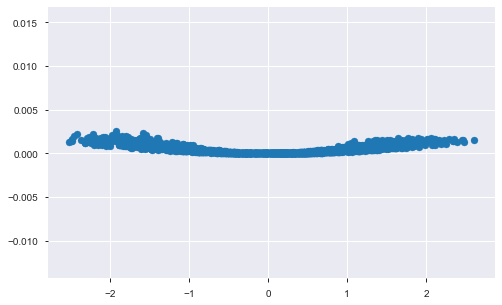

None

OLS for final dataset after pca_feat
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     105.7
Date:                Mon, 30 Dec 2019   Prob (F-statistic):          2.65e-246
Time:                        04:19:15   Log-Likelihood:                -1073.5
No. Observations:                2232   AIC:                             2179.
Df Residuals:                    2216   BIC:                             2270.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

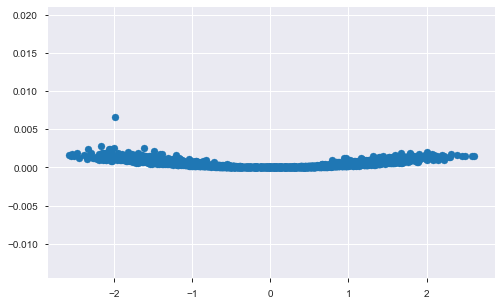

None

OLS for final dataset after selectkbest
                            OLS Regression Results                            
Dep. Variable:        log_total_spend   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     109.2
Date:                Mon, 30 Dec 2019   Prob (F-statistic):          4.21e-240
Time:                        04:19:24   Log-Likelihood:                -1090.4
No. Observations:                2232   AIC:                             2211.
Df Residuals:                    2217   BIC:                             2296.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

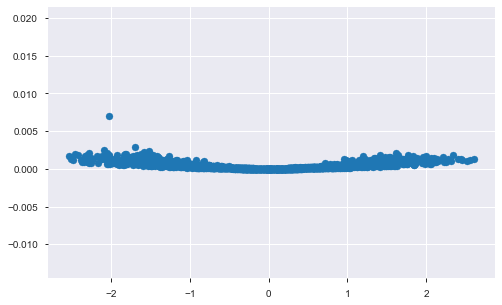

None


In [47]:
#OLS on refined dataset
ols=sm.OLS
print('OLS for final dataset')
apple=model_ols(ols,new_vif_feat,new_pre)
print()
print('OLS for final dataset after pca_feat')
ball=model_ols(ols,new_pca_feat,new_pre)
print()
print('OLS for final dataset after selectkbest')
cat=model_ols(ols,new_kbest_feat,new_pre)

Filtering data with Cooks distance has imporved our r2 score by ~10%

Below different models will be used to compare best score for different datasets created.

##### linear Regression

In [48]:
lr = LinearRegression(n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(lr,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(lr,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(lr,kbest_feat,pre)

print()
print()

print('Dataset after filtering cooks_distance')
print('Score of datasset after filtering cooks_distance:')
model_build_cum_evaluation(lr,new_vif_feat,new_pre)
print()
print('Score of dataset after filtering cooks_distance applying PCA:')
model_build_cum_evaluation(lr,new_pca_feat,new_pre)
print()
print('Score of datasset after filtering cooks_distance applying SelectKbest:')
model_build_cum_evaluation(lr,new_kbest_feat,new_pre)


Orginal data set:-
Score for original data set :
MAE: 0.365236132666872
MSE train: 0.21961817650735566
MSE test: 0.20118574916111032
RMSE: 0.44853734422131486
R2:  0.2845756679249444
Cross_val: 27.551501896856863

Score of orginal data set after PCA
MAE: 0.3606429405558338
MSE train: 0.2158399013094115
MSE test: 0.19777891904367742
RMSE: 0.4447234185914628
R2:  0.2966904880422767
Cross_val: 28.780329385555635

Sore of original data set after SelectKBest
MAE: 0.36114484438900235
MSE train: 0.21637630696868188
MSE test: 0.19807513422398612
RMSE: 0.4450563270238792
R2:  0.2956371353649301
Cross_val: 28.637397555731408


Dataset after filtering cooks_distance
Score of datasset after filtering cooks_distance:
MAE: 0.33767595336906586
MSE train: 0.1548969386122815
MSE test: 0.16663209865713902
RMSE: 0.4082059512759938
R2:  0.40271375421037825
Cross_val: 38.71968286165019

Score of dataset after filtering cooks_distance applying PCA:
MAE: 0.3376577655767951
MSE train: 0.15320930914643488
MSE 

##### Support Vector Regressor

In [49]:
# Support Vector Machine
svm = SVR()

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(svm,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(svm,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(svm,kbest_feat,pre)

print()
print()

print('Dataset after filtering cooks_distance')
print('Score of datasset after filtering cooks_distance:')
model_build_cum_evaluation(svm,new_vif_feat,new_pre)
print()
print('Score of dataset after filtering cooks_distance applying PCA:')
model_build_cum_evaluation(svm,new_pca_feat,new_pre)
print()
print('Score of datasset after filtering cooks_distance applying SelectKbest:')
model_build_cum_evaluation(svm,new_kbest_feat,new_pre)


Orginal data set:-
Score for original data set :
MAE: 0.37180399646615325
MSE train: 0.20855936171853295
MSE test: 0.2096178130746674
RMSE: 0.4578403794715658
R2:  0.2545909213982911
Cross_val: 25.641776201335432

Score of orginal data set after PCA
MAE: 0.3968762494051204
MSE train: 0.1447504967195351
MSE test: 0.24309991659991534
RMSE: 0.4930516368494433
R2:  0.13552726181554398
Cross_val: 14.21274083999204

Sore of original data set after SelectKBest
MAE: 0.39656788753915967
MSE train: 0.15483805385043928
MSE test: 0.24236511924390153
RMSE: 0.49230592038274484
R2:  0.1381402297311578
Cross_val: 14.081737268792399


Dataset after filtering cooks_distance
Score of datasset after filtering cooks_distance:
MAE: 0.34680087427578665
MSE train: 0.1466754861372083
MSE test: 0.17696200306551374
RMSE: 0.4206685192232879
R2:  0.3656866155428219
Cross_val: 37.03028013546627

Score of dataset after filtering cooks_distance applying PCA:
MAE: 0.3774202674401675
MSE train: 0.10259185100282023
MSE 

##### Random Forest Regressor

In [50]:
#Random Forest
random_forest = RandomForestRegressor(n_estimators=100,n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(random_forest,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(random_forest,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(random_forest,kbest_feat,pre)

print()
print()

print('Dataset after filtering cooks_distance')
print('Score of datasset after filtering cooks_distance:')
model_build_cum_evaluation(random_forest,new_vif_feat,new_pre)
print()
print('Score of dataset after filtering cooks_distance applying PCA:')
model_build_cum_evaluation(random_forest,new_pca_feat,new_pre)
print()
print('Score of datasset after filtering cooks_distance applying SelectKbest:')
model_build_cum_evaluation(random_forest,new_kbest_feat,new_pre)

Orginal data set:-
Score for original data set :
MAE: 0.3951887512519699
MSE train: 0.04028143276223573
MSE test: 0.23847532362730003
RMSE: 0.48833935293738107
R2:  0.15197249390751888
Cross_val: 15.884616710688618

Score of orginal data set after PCA
MAE: 0.3860886344181002
MSE train: 0.03661718974808314
MSE test: 0.22942736845826842
RMSE: 0.4789857706219136
R2:  0.18414737364149936
Cross_val: 20.515118416872255

Sore of original data set after SelectKBest
MAE: 0.38245002271214107
MSE train: 0.03795983842057657
MSE test: 0.22304259071159527
RMSE: 0.4722738513951363
R2:  0.20685189110313817
Cross_val: 20.314083157140402


Dataset after filtering cooks_distance
Score of datasset after filtering cooks_distance:
MAE: 0.35461530511204464
MSE train: 0.029005755738348675
MSE test: 0.18374908837775591
RMSE: 0.42865964164795817
R2:  0.341358573474864
Cross_val: 29.375497988110062

Score of dataset after filtering cooks_distance applying PCA:
MAE: 0.35005304253857505
MSE train: 0.02704377131042

##### Gradient Boosting Regressor

In [51]:
#Gradient Boost
gradient_boosted = GradientBoostingRegressor()

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(gradient_boosted,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(gradient_boosted,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(gradient_boosted,kbest_feat,pre)

print()
print()

print('Dataset after filtering cooks_distance')
print('Score of datasset after filtering cooks_distance:')
model_build_cum_evaluation(gradient_boosted,new_vif_feat,new_pre)
print()
print('Score of dataset after filtering cooks_distance applying PCA:')
model_build_cum_evaluation(gradient_boosted,new_pca_feat,new_pre)
print()
print('Score of datasset after filtering cooks_distance applying SelectKbest:')
model_build_cum_evaluation(gradient_boosted,new_kbest_feat,new_pre)


Orginal data set:-
Score for original data set :
MAE: 0.3702261525706795
MSE train: 0.19741241932055092
MSE test: 0.20594472987628812
RMSE: 0.45381133731572654
R2:  0.26765254780480274
Cross_val: 26.955870650020152

Score of orginal data set after PCA
MAE: 0.3687341602956102
MSE train: 0.1811792546642024
MSE test: 0.20649142656121577
RMSE: 0.45441327727214986
R2:  0.26570847317579516
Cross_val: 27.636435014232102

Sore of original data set after SelectKBest
MAE: 0.36633779520694104
MSE train: 0.1912580204583786
MSE test: 0.20228775881597108
RMSE: 0.4497641146378522
R2:  0.2806568788230499
Cross_val: 28.02457000360718


Dataset after filtering cooks_distance
Score of datasset after filtering cooks_distance:
MAE: 0.3443962904077529
MSE train: 0.13390581920231062
MSE test: 0.17101511578675846
RMSE: 0.4135397390659796
R2:  0.38700300059400206
Cross_val: 38.06671590528304

Score of dataset after filtering cooks_distance applying PCA:
MAE: 0.33841908786712793
MSE train: 0.12193582350110713
M

##### Lasso

In [52]:
#Lasso
ls = Lasso(alpha=0.001)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(ls,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(ls,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(ls,kbest_feat,pre)

print()
print()

print('Dataset after filtering cooks_distance')
print('Score of datasset after filtering cooks_distance:')
model_build_cum_evaluation(ls,new_vif_feat,new_pre)
print()
print('Score of dataset after filtering cooks_distance applying PCA:')
model_build_cum_evaluation(ls,new_pca_feat,new_pre)
print()
print('Score of datasset after filtering cooks_distance applying SelectKbest:')
model_build_cum_evaluation(ls,new_kbest_feat,new_pre)

Orginal data set:-
Score for original data set :
MAE: 0.3654167050477713
MSE train: 0.2197176237977574
MSE test: 0.20111368160157547
RMSE: 0.44845700083907203
R2:  0.28483194296360637
Cross_val: 27.572921009130557

Score of orginal data set after PCA
MAE: 0.36078672591557387
MSE train: 0.21591698879824078
MSE test: 0.19757849836058428
RMSE: 0.4444980296475838
R2:  0.29740319176972185
Cross_val: 28.81079390242551

Sore of original data set after SelectKBest
MAE: 0.361111572110444
MSE train: 0.21647245861721773
MSE test: 0.19780432535739328
RMSE: 0.44475198184762854
R2:  0.29660014220467923
Cross_val: 28.710872606493865


Dataset after filtering cooks_distance
Score of datasset after filtering cooks_distance:
MAE: 0.33809210913696874
MSE train: 0.15499772228727818
MSE test: 0.1666811879815362
RMSE: 0.40826607498240186
R2:  0.40253779544544743
Cross_val: 38.703624708929794

Score of dataset after filtering cooks_distance applying PCA:
MAE: 0.3376413025072482
MSE train: 0.15330050819523455

##### K Neighbors Regressor

In [53]:
#knn
knn = KNeighborsRegressor(n_neighbors=50,n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(knn,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(knn,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(knn,kbest_feat,pre)

print()
print()

print('Dataset after filtering cooks_distance')
print('Score of datasset after filtering cooks_distance:')
model_build_cum_evaluation(knn,new_vif_feat,new_pre)
print()
print('Score of dataset after filtering cooks_distance applying PCA:')
model_build_cum_evaluation(knn,new_pca_feat,new_pre)
print()
print('Score of datasset after filtering cooks_distance applying SelectKbest:')
model_build_cum_evaluation(knn,new_kbest_feat,new_pre)

Orginal data set:-
Score for original data set :
MAE: 0.38962654308044403
MSE train: 0.23158250731164232
MSE test: 0.22298764760173795
RMSE: 0.4722156791146795
R2:  0.20704727093414355
Cross_val: 21.917977032712557

Score of orginal data set after PCA
MAE: 0.40836972351927403
MSE train: 0.24905365447484495
MSE test: 0.24657687447033622
RMSE: 0.4965650757658418
R2:  0.12316306468691451
Cross_val: 14.781603306167106

Sore of original data set after SelectKBest
MAE: 0.40801872823189594
MSE train: 0.2492147411569105
MSE test: 0.24627216324824963
RMSE: 0.496258161895852
R2:  0.12424662961855637
Cross_val: 14.712942879070495


Dataset after filtering cooks_distance
Score of datasset after filtering cooks_distance:
MAE: 0.3561174244234377
MSE train: 0.1745855060670858
MSE test: 0.18498584581257776
RMSE: 0.4300998091287391
R2:  0.33692546478121976
Cross_val: 30.833765468489876

Score of dataset after filtering cooks_distance applying PCA:
MAE: 0.3825194315808064
MSE train: 0.19582805161154335


##### XGB Regressor

In [54]:
#xgboost
xg = XGBRegressor(n_jobs=-1)

print("Orginal data set:-")
print('Score for original data set :') 
model_build_cum_evaluation(xg,vif_feat,pre)
print()
print('Score of orginal data set after PCA')
model_build_cum_evaluation(xg,pca_feat,pre)
print()
print('Sore of original data set after SelectKBest')
model_build_cum_evaluation(xg,kbest_feat,pre)

print()
print()

print('Dataset after filtering cooks_distance')
print('Score of datasset after filtering cooks_distance:')
model_build_cum_evaluation(xg,new_vif_feat,new_pre)
print()
print('Score of dataset after filtering cooks_distance applying PCA:')
model_build_cum_evaluation(xg,new_pca_feat,new_pre)
print()
print('Score of datasset after filtering cooks_distance applying SelectKbest:')
model_build_cum_evaluation(xg,new_kbest_feat,new_pre)

Orginal data set:-
Score for original data set :
[04:27:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.36861620858867716
MSE train: 0.19919891410010593
MSE test: 0.20413786874205123
RMSE: 0.45181618911018584
R2:  0.27407781612278204
Cross_val: 26.967835960808618

Score of orginal data set after PCA
[04:27:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.36895661043820305
MSE train: 0.18213083993800713
MSE test: 0.204796461790324
RMSE: 0.45254443073616984
R2:  0.27173583368299936
Cross_val: 27.638308794723564

Sore of original data set after SelectKBest
[04:28:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.36594487981317025
MSE train: 0.19298265023411224
MSE test: 0.20258467828613258
RMSE: 0.45009407715069144
R2:  0.2796010216636531
Cross_val: 28.074123267063655


Dataset after filteri

    Highest cross val score was obtained by Linear Regresssion - 39.200078657653656 on refined PCA dataset.

In [55]:
# Converting coefficient data to data frame and saving it
importance = pd.DataFrame(ls.coef_)

In [56]:
#extracting columns
columns = pd.DataFrame(new_vif_feat.columns)

<BarContainer object of 15 artists>

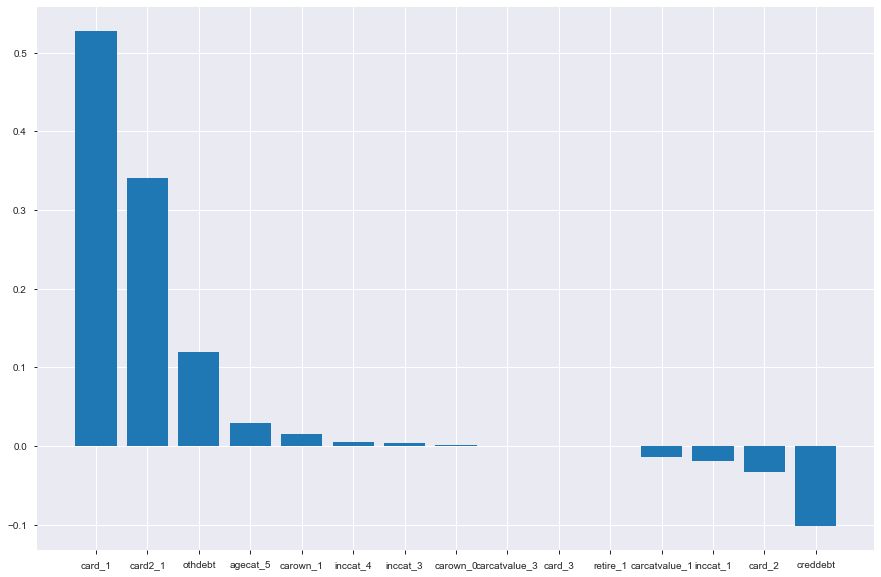

In [57]:
#Merging data to form new data frame
importance_table = pd.concat([columns,importance],axis=1)
importance_table.columns = ['col','importance']
importance_table.sort_values(by='importance',ascending=False,inplace=True)
plt.figure(figsize=(15,10))
plt.bar(importance_table['col'],importance_table['importance'])

##### From the data above we can conclude the following attributes that drive credit card spend of a customer:-
 
    card_1   :- Primary credit card - American Express 
    card2_1  :- Secondary credit card - American Express 
    othdebt  :- Other debts in thousand
    
    If a person owns two American Express cards and has other debts to clear, then the credit limit should be incresed.
       